# Setup

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [9]:
# Read raw data
df_X = pd.read_csv("../../../data/raw/train_values.csv")
df_y = pd.read_csv("../../../data/raw/train_labels.csv")
df_raw = df_X.merge(df_y, on='building_id')
df_raw_test = pd.read_csv("../../../data/raw/test_values.csv")

In [10]:
# Direcotry variables
dir_data_interim = "../data/interim/"
dif_data_clean = "../data/clean/"

# Train-Validation Set Creation

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, _, _ = train_test_split(
    df_raw.values,
    df_raw['damage_grade'].values,
    stratify=df_raw['damage_grade'].values,
    test_size=0.2,
    random_state=3
)

df_raw_train = pd.DataFrame(X_train, columns=df_raw.columns).infer_objects()
df_raw_val = pd.DataFrame(X_val, columns=df_raw.columns).infer_objects()

(208480, 40)
(52121, 40)
(86868, 39)


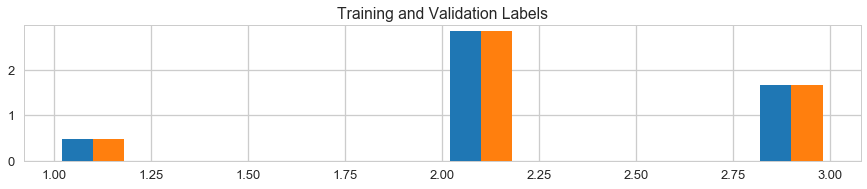

In [13]:
print(df_raw_train.shape)
print(df_raw_val.shape)
print(df_raw_test.shape)

plt.figure(figsize=(15, 2.5))
plt.hist([df_raw_train['damage_grade'].values, df_raw_val['damage_grade'].values], density=True)
plt.title("Training and Validation Labels")
plt.show()

# Feature Engineering

In [14]:
df_interim_train = df_raw_train
df_interim_val = df_raw_val
df_interim_test = df_raw_test

In [15]:
# Create ratio features
def create_interaction_features(df):
    return (df.assign(
        age_mul_area=df.age * df.area_percentage,
        age_div_area=df.age / df.area_percentage.replace(0, 0.1),
        age_mul_fam=df.age * df.count_families,
        age_div_fam=df.age / df.count_families.replace(0, 0.1),
        area_mul_fam=df.area_percentage * df.count_families,
        area_div_fam=df.area_percentage / df.count_families.replace(0, 0.1)
    ))

df_interim_train = create_interaction_features(df_interim_train)
df_interim_val = create_interaction_features(df_interim_val)
df_interim_test = create_interaction_features(df_interim_test)

In [17]:
# Define categorical features
cat_feats = df_raw.select_dtypes(exclude='number').columns
cat_feats_geo_level_id = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [18]:
# Create categorical OHE features
df_interim_train = pd.concat([df_interim_train, pd.get_dummies(df_interim_train[cat_feats])], axis=1)
df_interim_val = pd.concat([df_interim_val, pd.get_dummies(df_interim_val[cat_feats])], axis=1)
df_interim_test = pd.concat([df_interim_test, pd.get_dummies(df_interim_test[cat_feats])], axis=1)

In [119]:
# Define features for label encoding
feats_to_label_encode = (
    list(cat_feats) + 
    cat_feats_geo_level_id + 
    ['age', 'area_percentage', 'height_percentage', 'count_families'] +        
    ['age_mul_area', 'age_div_area', 'age_mul_fam', 'age_div_fam', 'area_mul_fam', 'area_div_fam']
)

# Create mean label encoded features
damage_grade_dummies = pd.get_dummies(df_interim_train['damage_grade'], prefix='damage_grade')
for feat in feats_to_label_encode:
    mappings = (
        pd.concat([df_interim_train[feat], damage_grade_dummies], axis=1)
        .groupby(feat).mean()
        .to_dict()
    ) 
    df_interim_train["{}_labelEnc_1".format(feat)] = df_interim_train[feat].map(mappings['damage_grade_1'])
    df_interim_train["{}_labelEnc_2".format(feat)] = df_interim_train[feat].map(mappings['damage_grade_2'])
    df_interim_train["{}_labelEnc_3".format(feat)] = df_interim_train[feat].map(mappings['damage_grade_3'])
    df_interim_val["{}_labelEnc_1".format(feat)] = df_interim_val[feat].map(mappings['damage_grade_1'])
    df_interim_val["{}_labelEnc_2".format(feat)] = df_interim_val[feat].map(mappings['damage_grade_2'])
    df_interim_val["{}_labelEnc_3".format(feat)] = df_interim_val[feat].map(mappings['damage_grade_3'])
    df_interim_test["{}_labelEnc_1".format(feat)] = df_interim_test[feat].map(mappings['damage_grade_1'])
    df_interim_test["{}_labelEnc_2".format(feat)] = df_interim_test[feat].map(mappings['damage_grade_2'])
    df_interim_test["{}_labelEnc_3".format(feat)] = df_interim_test[feat].map(mappings['damage_grade_3'])
    
# Create standard deviation label encoded features
damage_grade_dummies = pd.get_dummies(df_interim_train['damage_grade'], prefix='damage_grade')
for feat in feats_to_label_encode:
    mappings = (
        pd.concat([df_interim_train[feat], damage_grade_dummies], axis=1)
        .groupby(feat).std()
        .to_dict()
    )
    df_interim_train["{}_labelEncStd_1".format(feat)] = df_interim_train[feat].map(mappings['damage_grade_1'])
    df_interim_train["{}_labelEncStd_2".format(feat)] = df_interim_train[feat].map(mappings['damage_grade_2'])
    df_interim_train["{}_labelEncStd_3".format(feat)] = df_interim_train[feat].map(mappings['damage_grade_3'])
    df_interim_val["{}_labelEncStd_1".format(feat)] = df_interim_val[feat].map(mappings['damage_grade_1'])
    df_interim_val["{}_labelEncStd_2".format(feat)] = df_interim_val[feat].map(mappings['damage_grade_2'])
    df_interim_val["{}_labelEncStd_3".format(feat)] = df_interim_val[feat].map(mappings['damage_grade_3'])
    df_interim_test["{}_labelEncStd_1".format(feat)] = df_interim_test[feat].map(mappings['damage_grade_1'])
    df_interim_test["{}_labelEncStd_2".format(feat)] = df_interim_test[feat].map(mappings['damage_grade_2'])
    df_interim_test["{}_labelEncStd_3".format(feat)] = df_interim_test[feat].map(mappings['damage_grade_3'])

In [121]:
# Catigorical: drop original columns
df_interim_train = df_interim_train.drop(list(cat_feats) + cat_feats_geo_level_id, axis=1)
df_interim_val = df_interim_val.drop(list(cat_feats) + cat_feats_geo_level_id, axis=1)
df_interim_test = df_interim_test.drop(list(cat_feats) + cat_feat_geo_level_id, axis=1)

In [122]:
n_feats = df_interim_train.drop(['damage_grade', 'building_id'], axis=1).shape[1]
n = df_interim_train.shape[0]

print("Num features: {}".format(n_feats))
print("Features to data ratio: {:.3}".format(n_feats / n))
display(df_interim_train.head())

Num features: 197
Features to data ratio: 0.00113


,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,age_div_area,age_div_fam,age_mul_area,age_mul_fam,area_div_fam,area_mul_fam,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,land_surface_condition_labelEnc_1,land_surface_condition_labelEnc_2,land_surface_condition_labelEnc_3,foundation_type_labelEnc_1,foundation_type_labelEnc_2,foundation_type_labelEnc_3,roof_type_labelEnc_1,roof_type_labelEnc_2,roof_type_labelEnc_3,ground_floor_type_labelEnc_1,ground_floor_type_labelEnc_2,ground_floor_type_labelEnc_3,other_floor_type_labelEnc_1,other_floor_type_labelEnc_2,other_floor_type_labelEnc_3,position_labelEnc_1,position_labelEnc_2,position_labelEnc_3,plan_configuration_labelEnc_1,plan_configuration_labelEnc_2,plan_configuration_labelEnc_3,legal_ownership_status_labelEnc_1,legal_ownership_status_labelEnc_2,legal_ownership_status_labelEnc_3,geo_level_1_id_labelEnc_1,geo_level_1_id_labelEnc_2,geo_level_1_id_labelEnc_3,geo_level_2_id_labelEnc_1,geo_level_2_id_labelEnc_2,geo_level_2_id_labelEnc_3,geo_level_3_id_labelEnc_1,geo_level_3_id_labelEnc_2,geo_level_3_id_labelEnc_3,age_labelEnc_1,age_labelEnc_2,age_labelEnc_3,area_percentage_labelEnc_1,area_percentage_labelEnc_2,area_percentage_labelEnc_3,height_percentage_labelEnc_1,height_percentage_labelEnc_2,height_percentage_labelEnc_3,count_families_labelEnc_1,count_families_labelEnc_2,count_families_labelEnc_3,age_mul_area_labelEnc_1,age_mul_area_labelEnc_2,age_mul_area_labelEnc_3,age_div_area_labelEnc_1,age_div_area_labelEnc_2,age_div_area_labelEnc_3,age_mul_fam_labelEnc_1,age_mul_fam_labelEnc_2,age_mul_fam_labelEnc_3,age_div_fam_labelEnc_1,age_div_fam_labelEnc_2,age_div_fam_labelEnc_3,area_mul_fam_labelEnc_1,area_mul_fam_labelEnc_2,area_mul_fam_labelEnc_3,area_div_fam_labelEnc_1,area_div_fam_labelEnc_2,area_div_fam_labelEnc_3,land_surface_condition_labelEncStd_1,land_surface_condition_labelEncStd_2,land_surface_condition_labelEncStd_3,foundation_type_labelEncStd_1,foundation_type_labelEncStd_2,foundation_type_labelEncStd_3,roof_type_labelEncStd_1,roof_type_labelEncStd_2,roof_type_labelEncStd_3,ground_floor_type_labelEncStd_1,ground_floor_type_labelEncStd_2,ground_floor_type_labelEncStd_3,other_floor_type_labelEncStd_1,other_floor_type_labelEncStd_2,other_floor_type_labelEncStd_3,position_labelEncStd_1,position_labelEncStd_2,position_labelEncStd_3,plan_configuration_labelEncStd_1,plan_configuration_labelEncStd_2,plan_configuration_labelEncStd_3,legal_ownership_status_labelEncStd_1,legal_ownership_status_labelEncStd_2,legal_ownership_status_labelEncStd_3,geo_level_1_id_labelEncStd_1,geo_level_1_id_labelEncStd_2,geo_level_1_id_labelEncStd_3

In [20]:
# Save interim data
df_interim_train.to_csv("{}train.csv".format(dir_data_interim), index=False)
df_interim_val.to_csv("{}val.csv".format(dir_data_interim), index=False)
df_interim_test.to_csv("{}test.csv".format(dir_data_interim), index=False)